In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
from signal_modules.signal_registry import SignalRegistry
from backtesting.backtester import BacktestEngine
from investor.portfolio_registry import PortfolioRegistry

In [3]:
portfolio_registry = PortfolioRegistry()
portfolio_registry.available()

['default']

In [4]:
default_portfolio = portfolio_registry.get('default')

In [5]:
tickers = ["SPY", "NVDA", "TSLA", "AAPL", "MSFT", "AMZN", "META", "GOOGL", "AVGO", "BRK-B", "GOOG", "JPM"]  # List of tickers
data = {ticker: pd.read_parquet(os.path.join(data_path, f"{ticker}.parquet")) for ticker in tickers}
data = {tk: df.loc[default_portfolio.portfolio.initial_time:] for tk, df in data.items()}

data = {tk: df.iloc[:] for tk, df in data.items()}
data['SPY'].tail()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2025-05-12 00:00:00+00:00,582.99,583.00,577.0400,581.47,78993570,582.99,583.00,577.0400,581.47,78993570,0.0,1.0
2025-05-13 00:00:00+00:00,586.84,589.08,582.8400,583.41,67947225,586.84,589.08,582.8400,583.41,67947225,0.0,1.0
2025-05-14 00:00:00+00:00,587.59,588.98,585.5350,587.81,66283531,587.59,588.98,585.5350,587.81,66283531,0.0,1.0
2025-05-15 00:00:00+00:00,590.46,590.97,585.0969,585.56,71268145,590.46,590.97,585.0969,585.56,71268145,0.0,1.0
2025-05-16 00:00:00+00:00,594.20,594.50,589.2800,591.25,71977042,594.20,594.50,589.2800,591.25,71977042,0.0,1.0


In [6]:
signal_registry = SignalRegistry()

In [7]:
signal_registry.available_signals()

['ma_crossover', 'Kalman']

In [8]:
model2 = signal_registry.get('ma_crossover')()
model3 = signal_registry.get('Kalman')()

In [9]:
bt = BacktestEngine(
    data = data, 
    modules_weights = [(model3, 1)], 
    manager=default_portfolio
)

In [10]:
bt.run()

Backtesting:   0%|          | 0/1351 [00:00<?, ?it/s]c:\Users\nafiz\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
Backtesting: 100%|██████████| 1351/1351 [00:30<00:00, 43.69it/s]


2020-01-02 00:00:00+00:00      5000.000000
2020-01-03 00:00:00+00:00      5000.000000
2020-01-06 00:00:00+00:00      4999.778000
2020-01-07 00:00:00+00:00      5208.425838
2020-01-08 00:00:00+00:00      5299.990516
                                 ...      
2025-05-12 00:00:00+00:00    613309.694165
2025-05-13 00:00:00+00:00    620790.699165
2025-05-14 00:00:00+00:00    640436.975062
2025-05-15 00:00:00+00:00    638666.484165
2025-05-16 00:00:00+00:00    638345.709165
Length: 1351, dtype: float64


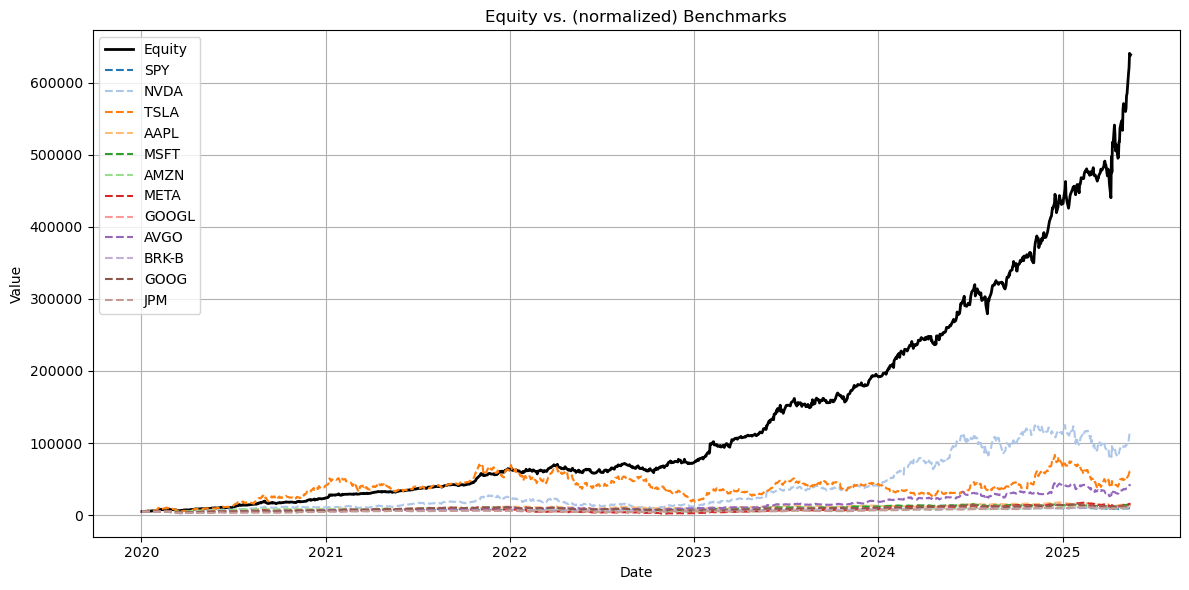

In [11]:
bt.equity_vs_benchmarks(benchmarks=tickers)

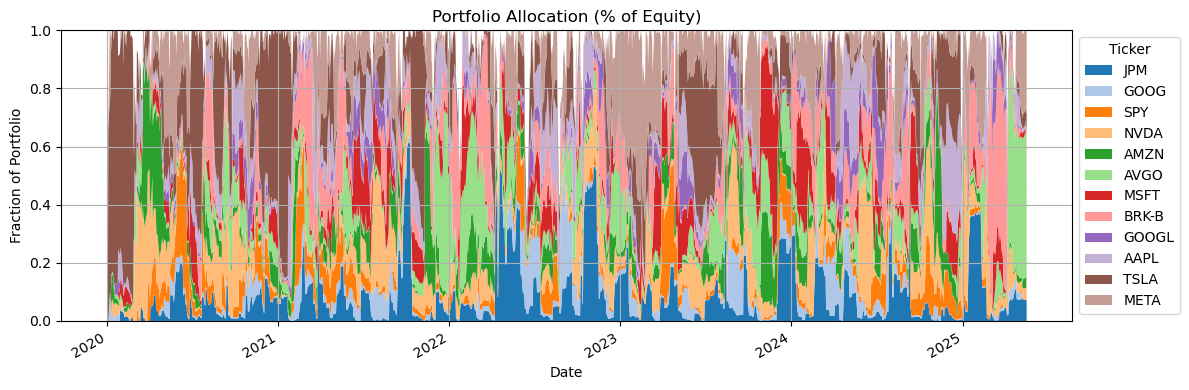

In [12]:
bt.holdings_over_time()

In [13]:
len(bt.manager.portfolio.order_history)

4567

<h1> Sanity Check </h1>

In [14]:
bt.manager.portfolio.order_history[:20]

[Order(ticker='TSLA', size=111, price=29.3666666667, timestamp=Timestamp('2020-01-03 00:00:00+0000', tz='UTC'), slippage=0.0, commission=0.0),
 Order(ticker='META', size=6, price=205.7389191172, timestamp=Timestamp('2020-01-06 00:00:00+0000', tz='UTC'), slippage=0.0, commission=0.0),
 Order(ticker='GOOG', size=5, price=67.1775828966, timestamp=Timestamp('2020-01-06 00:00:00+0000', tz='UTC'), slippage=0.0, commission=0.0),
 Order(ticker='GOOGL', size=1, price=67.2558032475, timestamp=Timestamp('2020-01-06 00:00:00+0000', tz='UTC'), slippage=0.0, commission=0.0),
 Order(ticker='NVDA', size=10, price=5.7833191131, timestamp=Timestamp('2020-01-06 00:00:00+0000', tz='UTC'), slippage=0.0, commission=0.0),
 Order(ticker='TSLA', size=1, price=29.3646666667, timestamp=Timestamp('2020-01-06 00:00:00+0000', tz='UTC'), slippage=0.0, commission=0.0),
 Order(ticker='META', size=-5, price=212.0096263762, timestamp=Timestamp('2020-01-08 00:00:00+0000', tz='UTC'), slippage=0.0, commission=0.0),
 Order(

In [15]:
"""
start with initial cash.
go through order history, update cash according to buy/sell.
make sure cash never goes negatie. i have allowd upto -100 because order recommendations
are generated based on previous day's closing price. next day's opening price, when the
order is executed, may be a bit higher, requiring slightly negative cash.
update position as we go along, and check if it ever goes negative
"""

"""
it is crucial to note that after backtesting is run on default_portfolio, it's internal states is changed.
at this point, even calling portfolio_registry.get('default') will return the changed version of 
the default portfolio. one must initiate a new registry and get a vanilla portfolio from there if needed.
"""

cash = PortfolioRegistry().get('default').cash
pos = PortfolioRegistry().get('default').positions
print("starting cash: ", cash)
print("starting position: ", pos)
for order in bt.manager.portfolio.order_history:
    cash -= data[order.ticker]['adjOpen'].loc[order.timestamp] * order.size
    current = pos.get(order.ticker, 0)
    pos[order.ticker] = current + order.size
    if cash < -10:
        print(data[order.ticker]['adjOpen'].loc[order.timestamp], " ", order.price)
        print("negative cash: ", cash)
    if pos[order.ticker] < 0:
        print(order.ticker, " ", order.timestamp)
        print("negative position")


print("final cash: ", cash)
print("final position: ", pos)

starting cash:  5000.0
starting position:  {}
final cash:  6325.214164874727
final position:  {'TSLA': 101.0, 'META': 273.0, 'GOOG': 33.0, 'GOOGL': 64.0, 'NVDA': 172.0, 'AMZN': 105.0, 'AVGO': 677.0, 'AAPL': 24.0, 'MSFT': 17.0, 'JPM': 175.0, 'BRK-B': 221.0, 'SPY': 54.0}


In [16]:
bt.manager.portfolio.positions

{'AMZN': Position(ticker='AMZN', size=105.0, last_trade_time=Timestamp('2025-05-12 00:00:00+0000', tz='UTC')),
 'GOOGL': Position(ticker='GOOGL', size=64.0, last_trade_time=Timestamp('2025-05-16 00:00:00+0000', tz='UTC')),
 'JPM': Position(ticker='JPM', size=175.0, last_trade_time=Timestamp('2025-05-14 00:00:00+0000', tz='UTC')),
 'GOOG': Position(ticker='GOOG', size=33.0, last_trade_time=Timestamp('2025-05-16 00:00:00+0000', tz='UTC')),
 'MSFT': Position(ticker='MSFT', size=17.0, last_trade_time=Timestamp('2025-05-13 00:00:00+0000', tz='UTC')),
 'NVDA': Position(ticker='NVDA', size=172.0, last_trade_time=Timestamp('2025-05-13 00:00:00+0000', tz='UTC')),
 'AAPL': Position(ticker='AAPL', size=24.0, last_trade_time=Timestamp('2025-05-14 00:00:00+0000', tz='UTC')),
 'AVGO': Position(ticker='AVGO', size=677.0, last_trade_time=Timestamp('2025-05-16 00:00:00+0000', tz='UTC')),
 'TSLA': Position(ticker='TSLA', size=101.0, last_trade_time=Timestamp('2025-05-14 00:00:00+0000', tz='UTC')),
 'SPY

In [17]:
"""
compute equity by adding up final cash and final position value.
for position we use the position calculated in the last step, 
as opposed to the output of the backtesting.
for ticker prices we use the final entry of the original dataframes, 
as opposed to the output of the backtesting.
"""
eq = cash + np.sum([pos[tk] * data[tk]['adjClose'].iloc[-1] for tk in bt.manager.positions])
print(eq)

637657.2241648746
